In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.regularizers import l2

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Dataset/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "" # You may need to change this, depending on where your datasets folder is
# dataset_dir = os.path.join(base_dir, "")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The three datasets need to be loaded in before the neural networks can be modelled.

In [ ]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="int", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="int", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="int", image_size=(224, 224))

Found 150 files belonging to 3 classes.
Found 75 files belonging to 3 classes.
Found 75 files belonging to 3 classes.


Lets start by creating a network with a large amount of layers and neurons as these can be adjusted to account for overfitting or not. The images are coloured so the input depth should be 3, additionally it is multiclass classification of 3 classes so there should be 3 neurons in the final layer with an activation function of softmax.

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# convnet.summary()

In [ ]:
convnet_history = convnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                verbose=0)

Accuracy: 1.0
Val_loss: 0.34207189083099365
Loss: 0.03128848224878311


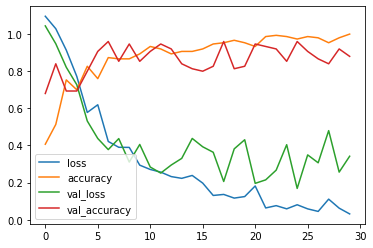

In [ ]:
pd.DataFrame(convnet_history.history).plot()
print("Accuracy: " + str(convnet_history.history["accuracy"][-1]))
print("Val_loss: " + str(convnet_history.history["val_loss"][-1]))
print("Loss: " + str(convnet_history.history["loss"][-1]))
# print(convnet_history.history)

As the above plot shows a higher validation loss than training loss so the model is probably overfitting. This can be tackled in a number of ways; reducing the size of the network, increasing the number of samples to train on, weight regularisation, dropout or early stopping. Lets start by adding early stopping. 


In [ ]:
convnet_early_history = convnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 1.0
Val_loss: 0.31774118542671204
Loss: 0.010407870635390282


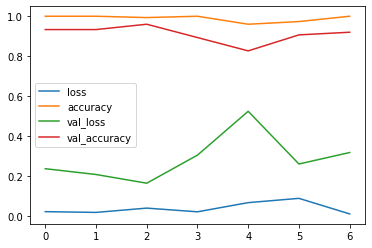

In [ ]:
pd.DataFrame(convnet_early_history.history).plot()
print("Accuracy: " + str(convnet_early_history.history["accuracy"][-1]))
print("Val_loss: " + str(convnet_early_history.history["val_loss"][-1]))
print("Loss: " + str(convnet_early_history.history["loss"][-1]))
# print(convnet_early_history.history)

The model is still overfitting but there is a slight drop so lets keep early stopping. Lets try halving the number of neurons in the second last dense layer and removing one of the convolution layers. By doing so the number of learnable parameters should drop, making the model less complex.

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
# x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
convnet2 = Model(inputs, outputs)
convnet2.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
convnet2_history = convnet2.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 0.9333333373069763
Val_loss: 0.3306065797805786
Loss: 0.2158813774585724


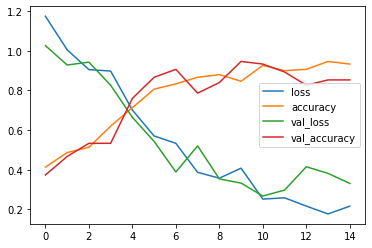

In [ ]:
pd.DataFrame(convnet2_history.history).plot()
print("Accuracy: " + str(convnet2_history.history["accuracy"][-1]))
print("Val_loss: " + str(convnet2_history.history["val_loss"][-1]))
print("Loss: " + str(convnet2_history.history["loss"][-1]))
# print(convnet_history.history)

Lets reduce the size of the model further as the model is still overfitting.

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
# x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
convnet3 = Model(inputs, outputs)
convnet3.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
convnet3_history = convnet3.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 0.9266666769981384
Val_loss: 0.2522111237049103
Loss: 0.18606209754943848


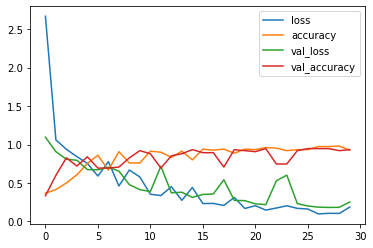

In [ ]:
pd.DataFrame(convnet3_history.history).plot()
print("Accuracy: " + str(convnet3_history.history["accuracy"][-1]))
print("Val_loss: " + str(convnet3_history.history["val_loss"][-1]))
print("Loss: " + str(convnet3_history.history["loss"][-1]))
# print(convnet_history.history)

Now lets try to add dropout to our network to further reduce overfitting. This should make our model more general and it should work better with unseen data. Typically dropout increases the number of epochs needed for convergence so lets increase this from 30 to 50.

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)
outputs = Dense(3, activation="softmax")(x)
dropout_convnet3 = Model(inputs, outputs)
dropout_convnet3.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
dropout_convnet3_history = dropout_convnet3.fit(train_dataset, epochs=50, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 1.0
Val_loss: 0.2532041370868683
Loss: 0.049400150775909424


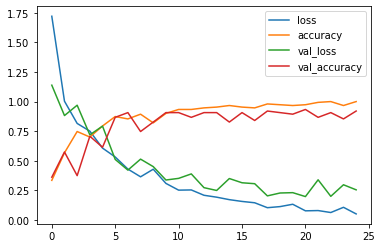

In [ ]:
pd.DataFrame(dropout_convnet3_history.history).plot()
print("Accuracy: " + str(dropout_convnet3_history.history["accuracy"][-1]))
print("Val_loss: " + str(dropout_convnet3_history.history["val_loss"][-1]))
print("Loss: " + str(dropout_convnet3_history.history["loss"][-1]))
# print(dropout_convnet3_history.history)

Lets try incorporating some Batch Normalisation layers into the neural network to act as a regulariser and allow for larger learning rates to work as these are less likely to diverge.

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
outputs = Dense(3, activation="softmax")(x)
batch_convnet3 = Model(inputs, outputs)
batch_convnet3.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
batch_convnet3_history = batch_convnet3.fit(train_dataset, epochs=50, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 1.0
Val_loss: 0.9877258539199829
Loss: 0.009950296021997929


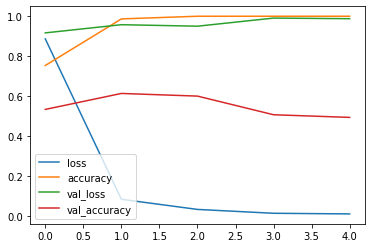

In [ ]:
pd.DataFrame(batch_convnet3_history.history).plot()
print("Accuracy: " + str(batch_convnet3_history.history["accuracy"][-1]))
print("Val_loss: " + str(batch_convnet3_history.history["val_loss"][-1]))
print("Loss: " + str(batch_convnet3_history.history["loss"][-1]))
# print(batch_convnet3_history.history)

Batch Normalisation increased the amount of overfitting. Try Weight regularisation instead. Adding constraints should reduce complexity in an overfitting network.

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(0.0001))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(0.0001))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.25)(x)
outputs = Dense(3, activation="softmax", kernel_regularizer=l2(0.0001))(x)
regularisation_convnet = Model(inputs, outputs)
regularisation_convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
regularisation_convnet_history = regularisation_convnet.fit(train_dataset, epochs=50, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 1.0
Val_loss: 0.21409764885902405
Loss: 0.060257688164711


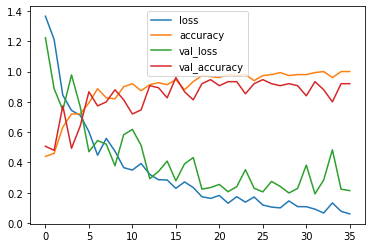

In [ ]:
pd.DataFrame(regularisation_convnet_history.history).plot()
print("Accuracy: " + str(regularisation_convnet_history.history["accuracy"][-1]))
print("Val_loss: " + str(regularisation_convnet_history.history["val_loss"][-1]))
print("Loss: " + str(regularisation_convnet_history.history["loss"][-1]))
# print(dropout_convnet3_history.history)

Adding both dropout and weight regularisation did not reduce the amount of overfitting so just dropout will be used from now. As the amount that the model is overfitting has dropped using dropout and by reducing the network size, lets try to increase the number of samples the network can train on. This can be achieved through data augmentation.


In [ ]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
x = Rescaling(scale=1./255)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)
outputs = Dense(3, activation="softmax")(x)
augmentation_convnet3 = Model(inputs, outputs)
augmentation_convnet3.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
augmentation_convnet3_history = augmentation_convnet3.fit(train_dataset, epochs=50, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 0.6866666674613953
Val_loss: 0.461262971162796
Loss: 0.7125001549720764


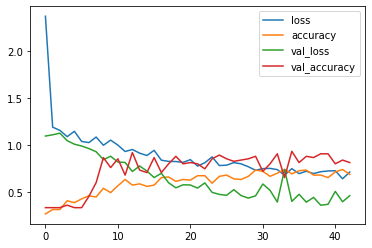

In [ ]:
pd.DataFrame(augmentation_convnet3_history.history).plot()
print("Accuracy: " + str(augmentation_convnet3_history.history["accuracy"][-1]))
print("Val_loss: " + str(augmentation_convnet3_history.history["val_loss"][-1]))
print("Loss: " + str(augmentation_convnet3_history.history["loss"][-1]))
# print(dropout_convnet3_history.history)

Now that we've tried a bunch of different methods to reduce the overfitting in our network, lets try using a pretrained network. We'll start with Resnet50.

In [ ]:
resnet50_base = ResNet50(weights = "imagenet", include_top = False, input_shape=(224, 224, 3))
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet50_base(x)
x = Flatten()(x)
outputs = Dense(3, activation="softmax")(x)
resnetbase = Model(inputs=inputs, outputs=outputs)
resnetbase.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
resnetbase_history = resnetbase.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 1.0
Val_loss: 0.08274147659540176
Loss: 5.2259651965869125e-06


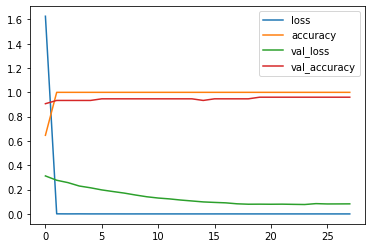

In [ ]:
pd.DataFrame(resnetbase_history.history).plot()
print("Accuracy: " + str(resnetbase_history.history["accuracy"][-1]))
print("Val_loss: " + str(resnetbase_history.history["val_loss"][-1]))
print("Loss: " + str(resnetbase_history.history["loss"][-1]))
# print(resnetbase_history.history)

Lets try freezing the base of the pretrained network to add our furniture classifier on top of the weights learned by the pretrained network. 

In [ ]:
resnet50_base = ResNet50(weights = "imagenet", include_top = False, input_shape=(224, 224, 3))

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet50_base(x)
x = Flatten()(x)
outputs = Dense(3, activation="softmax")(x)
transfer_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
resnet50_base.trainable = False

In [ ]:
transfer_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
transfer_model_frozen_history = transfer_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

In [ ]:
for layer in resnet50_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
transfer_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

Accuracy: 1.0
Val_loss: 0.5437613725662231
Loss: 1.4531206034007482e-05


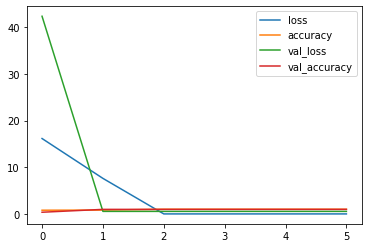

In [ ]:
pd.DataFrame(transfer_model_history.history).plot()
print("Accuracy: " + str(transfer_model_history.history["accuracy"][-1]))
print("Val_loss: " + str(transfer_model_history.history["val_loss"][-1]))
print("Loss: " + str(transfer_model_history.history["loss"][-1]))
# print(transfer_model_history.history)

Now that the model tuning is over lets start testing and evaluating the models.

In [ ]:
test_loss, test_acc = convnet.evaluate(test_dataset)

3/3 [==============================] - 8s 36ms/step - loss: 0.1948 - accuracy: 0.9200


In [ ]:
test_loss, test_acc = convnet2.evaluate(test_dataset)

3/3 [==============================] - 1s 29ms/step - loss: 0.2987 - accuracy: 0.8933


In [ ]:
test_loss, test_acc = convnet3.evaluate(test_dataset)

3/3 [==============================] - 1s 20ms/step - loss: 0.3355 - accuracy: 0.8400


In [ ]:
test_loss, test_acc = dropout_convnet3.evaluate(test_dataset)

3/3 [==============================] - 1s 18ms/step - loss: 0.2499 - accuracy: 0.9067


In [ ]:
test_loss, test_acc = batch_convnet3.evaluate(test_dataset)

3/3 [==============================] - 1s 20ms/step - loss: 0.9371 - accuracy: 0.5067


In [ ]:
test_loss, test_acc = regularisation_convnet.evaluate(test_dataset)

3/3 [==============================] - 1s 18ms/step - loss: 0.2405 - accuracy: 0.8933


In [ ]:
test_loss, test_acc = augmentation_convnet3.evaluate(test_dataset)

3/3 [==============================] - 1s 17ms/step - loss: 0.4718 - accuracy: 0.7867


In [ ]:
test_loss, test_acc = resnetbase.evaluate(test_dataset)

3/3 [==============================] - 1s 69ms/step - loss: 0.0323 - accuracy: 0.9867


In [ ]:
test_loss, test_acc = transfer_model.evaluate(test_dataset)

3/3 [==============================] - 1s 68ms/step - loss: 1.1656 - accuracy: 0.9333


Now lets save the best model; Resnetbase.

In [ ]:
resnetbase.save(os.path.join(base_dir, "best_network.h5"))